<a href="https://colab.research.google.com/github/caganze/wisps/blob/master/supervised_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install --upgrade tables

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, KFold,RepeatedKFold, GridSearchCV,  RandomizedSearchCV

import seaborn as sns
import pandas as pd
from scipy import stats
%matplotlib inline
from google.colab import drive #to import my own module, I must first follow this procedure:
drive.mount('/content/gdrive')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Mounted at /content/gdrive


In [ ]:

%%capture

'''
#latex


! sudo apt-get install texlive-latex-recommended #1
! sudo apt-get install texlive-latex-extra texlive-fonts-recommended dvipng
#! sudo apt-get install cm-super
! sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended 
! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip #3
! unzip type1cm.zip -d /tmp/type1cm #4
! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins  #5
! sudo mkdir /usr/share/texmf/tex/latex/type1cm #6
! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm #7
! sudo texhash #8

'''

In [ ]:
import matplotlib as mpl
#matplotlib defaults
mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['grid.linewidth'] = 0.5
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['font.size'] = 18
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'large'
mpl.rcParams['xtick.bottom']=True
mpl.rcParams['xtick.top']=True
mpl.rcParams['xtick.major.width']=0.9
mpl.rcParams['xtick.minor.width']=0.9
mpl.rcParams['ytick.major.width']=0.9
mpl.rcParams['ytick.minor.width']=0.9
mpl.rcParams['ytick.right']=True
mpl.rcParams['ytick.left']=True
mpl.rcParams['xtick.direction']='in'
mpl.rcParams['ytick.direction']='in'



mpl.rc('xtick', labelsize=18) 
mpl.rc('ytick', labelsize=18) 
font = {'family' : 'Helvetica',
        'size'   : 18}
mpl.rc('font', **font)
mpl.rc('text', usetex=False)
mpl.rcParams['agg.path.chunksize'] = 10000

In [ ]:
SEED=5 #for reproducibility

In [ ]:
#functions

def reformat_table(df):
  """
  drop uncertainties in the indidces 
  """
  new_df=pd.DataFrame()
  for k in df.columns: 
      if isinstance(df[k].iloc[0], tuple):
          new_df[k]=np.array(np.apply_along_axis(list, 0, df[k].values))[:,0]
          new_df[k+'_er']=np.array(np.apply_along_axis(list, 0, df[k].values))[:,1]
      else:
          new_df[k]=df[k].values
  return new_df

def apply_scale(x):
    ##put features on a log scale
    #replace nans
    y=x
    if np.isnan(y) or np.isinf(y) or abs(y) > 1e10:
        y=-99
    return y

def create_labels(row):
    #use multiclass system
    label=0
    if np.logical_or(row.label=='galax', row.label =='trash'):
      label=0
    if np.logical_and(row.spt <17, row.label=='sf'):
      label=1
    if np.logical_and(row.spt <17, row.label=='spex'):
      label=1
    if ((row.label=='man')| (row.label=='sf') | (row.label=='spex')) & np.logical_and(row.spt >=17, row.spt<20):
      label=2
    if ((row.label=='man')| (row.label=='sf')| (row.label=='spex')) & np.logical_and(row.spt >=20, row.spt<30):
      label=3
    if ((row.label=='man')| (row.label=='sf')| (row.label=='spex'))& np.logical_and(row.spt >=30, row.spt<45):
      label=4
    if row.label=='schn':
      label=4
    return label

def get_multi_labels(labels):
  multi_label = []
  for label in labels:
    if label == 0:
      multi_label.append([1,0,0,0,0])
    elif label ==1:
      multi_label.append([0,1,0,0,0])
    elif label == 2:
      multi_label.append([0,0,1,0,0])
    elif label == 3:
      multi_label.append([0,0,0,1,0])
    else:
      multi_label.append([0,0,0,0,1])
  return multi_label

def reverse_multilabel(label):
  #reverse multilabel
  if label == [1,0,0,0,0]:
     return 0
  if label == [0,1,0,0,0]:
     return 1
  if label == [0,0,1,0,0]:
     return 2
  if label == [0,0,0,1,0]:
     return 3
  if label == [0,0,0,0,1]:
     return 4

drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
FOLDER='/content/gdrive/My Drive/codes/'
SEED= 5

features=['H_2O-1/J-Cont', 'H_2O-2/H_2O-1', 'H-cont/H_2O-1', 'CH_4/H_2O-1',
       'H_2O-2/J-Cont', 'H-cont/J-Cont', 'CH_4/J-Cont', 'H-cont/H_2O-2',
       'CH_4/H_2O-2', 'CH_4/H-Cont', 'H_2O-1+H_2O-2/J-Cont',
      'H_2O-1+H_2O-2/H-Cont', 'H_2O-1+CH_4/J-Cont', 'H_2O-2+CH_4/J-Cont',
      'H_2O-1+CH_4/H-Cont', 'H_2O-2+CH_4/H-Cont', 'spt',  'x', 'f_test', 'snr1', 'snr2', 'snr3', 'snr4']
#data
#data

pred_df=reformat_table(pd.read_pickle(FOLDER+'/master_dataset.pkl.gz'))
train_df0=reformat_table(pd.read_pickle(FOLDER+'/training_set.pkl.gz'))

pred_df['x']= pred_df['spex_chi']/pred_df['line_chi']
pred_df['dof']=pred_df.nG141

train_df0['x']=train_df0.spex_chi/train_df0.line_chi
train_df0['f_test']=stats.f.cdf(train_df0['x'],train_df0.dof-2 , train_df0.dof-2)
pred_df['f_test']=stats.f.cdf(pred_df['x'],pred_df.dof-2 , pred_df.dof-2)

#put some features for on log-scale
for c in features:
  if c not in ['spt', 'f_test', 'x']:
    pred_df.assign(c=np.log10(pred_df[c]))
    train_df0.assign(c=np.log10(train_df0[c]))

#stars and galaxies
galaxies=(pred_df.loc[pred_df.class_star ==0 ]).reset_index(drop=True)
stars=(pred_df.loc[pred_df.class_star !=0 ]).reset_index(drop=True)
galaxies['label']='galax'
train_df=pd.concat([train_df0, galaxies] ).reset_index(drop=True)



#ONLY pick the highest snr
high_train=train_df[train_df.snr1>=np.log10(3.)]

labels=high_train.apply(create_labels, axis=1).values
high_train[features]=(high_train[features]).applymap(apply_scale)

NameError: ignored

In [ ]:
for l in np.unique(labels):
  print (' {} objects for class {}'.format(len(labels[labels==l]), l))

 138318 objects for class 0
 2070 objects for class 1
 4686 objects for class 2
 23140 objects for class 3
 13501 objects for class 4


In [ ]:
high_train.shape

(181715, 60)

In [ ]:
#split into train, validation, test
X_train, X_test, y_train, y_test = train_test_split(high_train[features].values, labels, shuffle=True, test_size=0.25,  random_state=SEED)
weigths= sklearn.utils.class_weight.compute_class_weight('balanced', [0, 1, 2, 3, 4 ], labels )

In [ ]:
from sklearn.utils.fixes import loguniform
from scipy.stats import uniform

In [ ]:
# specify parameters and distributions to sample from
#use randomized search instead of grid search

model= RandomForestClassifier(warm_start=True, verbose=False, n_jobs=-1, class_weight='balanced', )

param_dist = {'max_depth':np.linspace(1, 1000, 10, dtype=int),
              'min_samples_split': np.linspace(1, 1000, 20, dtype=int),
              'n_estimators': np.linspace(1, 1000, 20, dtype=int), 
              'max_leaf_nodes':np.linspace(1, 1000, 20, dtype=int),
              'min_impurity_split': loguniform(1e-8, 1.),
              'oob_score': [True, False],
              'bootstrap': [True,False],
              'criterion':['gini', 'entropy']}
n_iter_search = 100
random_search = RandomizedSearchCV(model, param_distributions=param_dist,
                                   n_iter=n_iter_search, refit='f1_weighted',
                   scoring=['recall_macro','balanced_accuracy','f1_weighted','precision_weighted' ], n_jobs=-1)

In [ ]:
#%%capture
#random_search.fit(X_train, y_train)
#rf=random_search.best_estimator_

In [ ]:
#save the random forest
#rf_dict={'classifier': rf,
#           'feats':features}
#import pickle
#output_file='/content/gdrive/My Drive/codes/random_forest_classifier.pkl'
#with open(output_file, 'wb') as file:
#    pickle.dump(rf_dict,file)

In [ ]:
rf= pd.read_pickle('/content/gdrive/My Drive/codes/random_forest_classifier.pkl')['classifier']

In [ ]:
#cv_res_df=pd.DataFrame(random_search.cv_results_)

In [ ]:
#plt.plot(cv_res_df.param_n_estimators, cv_res_df.mean_test_precision_weighted, '.')

In [ ]:
#previous best classifier

In [ ]:
#rf.fit(X_train, y_train)

In [ ]:
X_train.shape, X_test.shape, y_test.shape

((136286, 23), (45429, 23), (45429,))

In [ ]:
pred_labels = rf.predict(X_test)
model_accuracy = accuracy_score(y_test, pred_labels)

print ('accuracy score {}'.format(model_accuracy))
classes=['Contaminants', '<M7', 'M7-L0', 'L', 'T']
cm = pd.DataFrame(confusion_matrix(y_test, pred_labels), 
                  columns=classes, index=classes)


accuracy score 0.9884875299918554


In [ ]:
#! sudo apt-get install texlive-latex-recommended 
#! sudo apt install texlive-latex-extra
#! sudo apt install dvipng

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


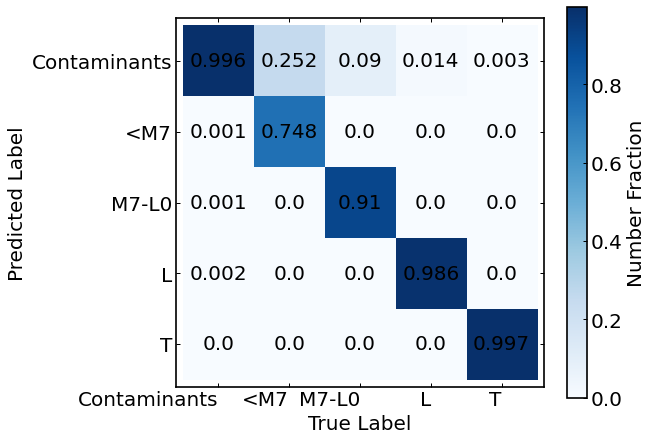

In [ ]:
#create a table a confusion matrix

fig, ax=plt.subplots(figsize=(8, 6))


matr=np.round(cm.values/np.sum(cm.values, axis=0), 3)
im = ax.imshow(matr, cmap='Blues')

# We want to show all ticks...
ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
# ... and label them with the respective list entries
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)

ax.set_xlabel('True Label', fontsize=18)
ax.set_ylabel('Predicted Label', fontsize=18)
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=0, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(classes)):
    for j in range(len(classes)):
        text = ax.text(j, i, matr[i, j], ha="center", va="center", color="k", fontsize=18)

cbar=plt.colorbar(im)
cbar.ax.set_ylabel('Number Fraction', fontsize=18)
        
ax.set_xlim([-0.6, 4.6])
ax.set_ylim([4.6, -0.6])

plt.tight_layout()



plt.savefig('/content/gdrive/My Drive/codes/confusion_matrix.pdf', bbox_inches='tight')

In [ ]:
from sklearn.metrics import classification_report
classification_report(y_test, pred_labels, output_dict=True)

{'0': {'f1-score': 0.9923985872709039,
  'precision': 0.9955384480797831,
  'recall': 0.9892784700086932,
  'support': 34510},
 '1': {'f1-score': 0.8358714043993233,
  'precision': 0.7484848484848485,
  'recall': 0.946360153256705,
  'support': 522},
 '2': {'f1-score': 0.9339893398933989,
  'precision': 0.9104716227018386,
  'recall': 0.9587542087542088,
  'support': 1188},
 '3': {'f1-score': 0.9861727106704931,
  'precision': 0.9855727446549626,
  'recall': 0.9867734075878872,
  'support': 5746},
 '4': {'f1-score': 0.9987022350396538,
  'precision': 0.9974078341013825,
  'recall': 1.0,
  'support': 3463},
 'accuracy': 0.9884875299918554,
 'macro avg': {'f1-score': 0.9494268554547546,
  'precision': 0.927495099604563,
  'recall': 0.9762332479214988,
  'support': 45429},
 'weighted avg': {'f1-score': 0.988765627486048,
  'precision': 0.9893571406412797,
  'recall': 0.9884875299918554,
  'support': 45429}}

In [ ]:
rf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=889, max_features='auto',
                       max_leaf_nodes=947, max_samples=None,
                       min_impurity_decrease=0.0,
                       min_impurity_split=0.018413643797822957,
                       min_samples_leaf=1, min_samples_split=53,
                       min_weight_fraction_leaf=0.0, n_estimators=474,
                       n_jobs=-1, oob_score=True, random_state=None,
                       verbose=False, warm_start=True)

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


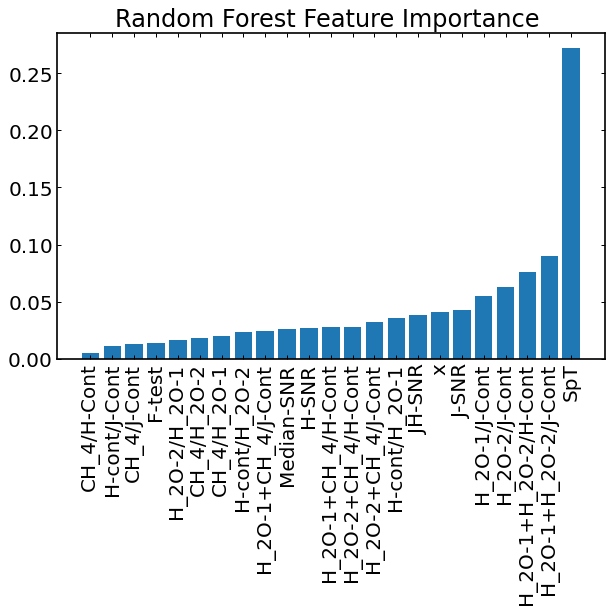

In [ ]:
fig, ax=plt.subplots(figsize=(8, 8))

feature_names=np.array((train_df[features]).rename(columns={'spt': 'SpT','snr1': 'J-SNR', 
                                                            'snr2':'JH-SNR', 'snr3': 'H-SNR', 
                                                            'snr4': 'Median-SNR', 'f_test': 'F-test'}).columns)

tree_feature_importances = (
    rf.feature_importances_)
    
sorted_idx = tree_feature_importances.argsort()

x_ticks = np.arange(0, len(feature_names))
ax.bar(x_ticks, tree_feature_importances[sorted_idx])
ax.set_xticklabels(feature_names[sorted_idx], rotation='vertical')
ax.set_xticks(x_ticks)
ax.set_title("Random Forest Feature Importance ")
plt.tight_layout()
plt.savefig('/content/gdrive/My Drive/codes/rf_feature_importance.pdf', bbox_inches='tight')


In [ ]:
rf.feature_importances_?

In [ ]:
stars=pred_df[pred_df.class_star !=0 ]
pred_set=reformat_table(stars).reset_index(drop=True)
pred_set[features]=pred_set[features].applymap(apply_scale)

#make predictiobs
rlabels=rf.predict(pred_set[features].values)
rprobs=rf.predict_proba(pred_set[features].values)
rlogprobs=rf.predict_log_proba(pred_set[features].values)

#compare to truth
detected=set((pred_set.loc[rlabels>0])['grism_id'].apply(lambda x: x.lower()).values)
truebds=set(pd.read_csv('/content/gdrive/My Drive/codes/true_brown_dwarfs.csv',names=['ignore', 'names'])['names'].apply(lambda x: x.lower()).values)

detected_set=pred_set[pred_set.grism_id.isin(list(detected))]
true_set=pred_set[pred_set.grism_id.isin(list(truebds))]
train_df_ucds=high_train[labels>0]

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:704: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


In [ ]:
#figure out how to get probabilities  out of this 

In [ ]:
#cmap=sns.cubehelix_palette(reverse=True, as_cmap=True)
cmap=sns.diverging_palette(150, 275, s=80, l=55, n=9, as_cmap=True)

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


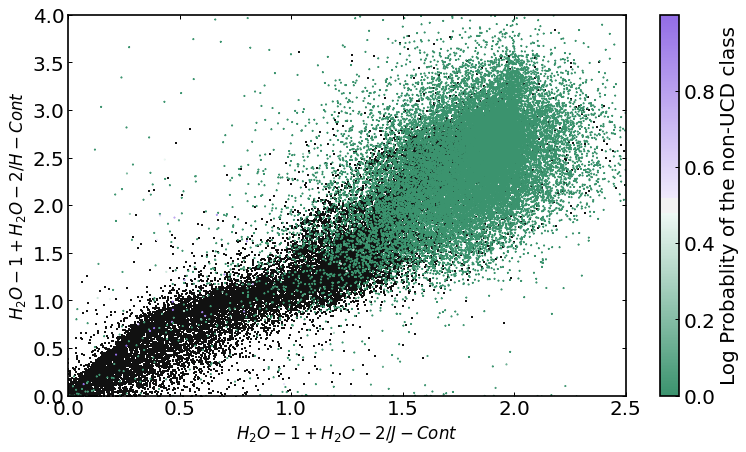

In [ ]:
#plot results
import seaborn as sns

fig, ax=plt.subplots(figsize=(10, 6))

subset=pred_set[rprobs[:,0] <0.9]

plt.scatter(train_df_ucds['H_2O-1+H_2O-2/J-Cont'], train_df_ucds['H_2O-1+H_2O-2/H-Cont'], s=1., 
            label='Training set',marker='+', c='#111111')

c=plt.scatter(subset['H_2O-1+H_2O-2/J-Cont'], subset['H_2O-1+H_2O-2/H-Cont'], marker='*', 
              s=1., c=(rprobs[:,-1])[rprobs[:,0] <0.9], alpha=1., cmap=cmap)
cbar=plt.colorbar(c)
cbar.ax.set_ylabel('Log Probablity of the non-UCD class', fontsize=18)
plt.xlim([0, 2.5])
plt.ylim([0, 4.])


ax.set_xlabel(r'$'+str('H_2O-1+H_2O-2/J-Cont$'), fontsize=15)
ax.set_ylabel(r'$'+str('H_2O-1+H_2O-2/H-Cont$'), fontsize=15)

plt.tight_layout()
plt.savefig('/content/gdrive/My Drive/codes/rf_colors.pdf', rasterized=True)


In [ ]:
truems=pred_set[pred_set.grism_id.isin(list(truebds)) & (pred_set.spt >=17) & (pred_set.spt <20)].grism_id.values
truels=pred_set[pred_set.grism_id.isin(list(truebds)) & ( pred_set.spt>=20) & (pred_set.spt <30)].grism_id.values
truets=pred_set[pred_set.grism_id.isin(list(truebds)) & (pred_set.spt>=30) & (pred_set.spt <50)].grism_id.values

In [ ]:
pred_set.shape

(104346, 59)

In [ ]:
recovs0=[]
for cut in np.linspace(0, 1, 20):
  ucds=len(list(set(pred_set[(rprobs[:,0] <1-cut) & (pred_set.grism_id.isin(list(truebds)))].grism_id.values)))/len(truebds)
  m0s=len(list(set(pred_set[(rprobs[:,2] > cut)& (pred_set.grism_id.isin(list(truems)))].grism_id.values)))/len(truems)
  l0s=len(list(set(pred_set[(rprobs[:,3] >cut)& (pred_set.grism_id.isin(list(truels)))].grism_id.values)))/len(truels)
  t0s=len(list(set(pred_set[(rprobs[:,4] >cut)& (pred_set.grism_id.isin(list(truets)))].grism_id.values)))/len(truets)
  recovs0.append([ucds, m0s, l0s, t0s])


In [ ]:
recovs=np.vstack(recovs0)

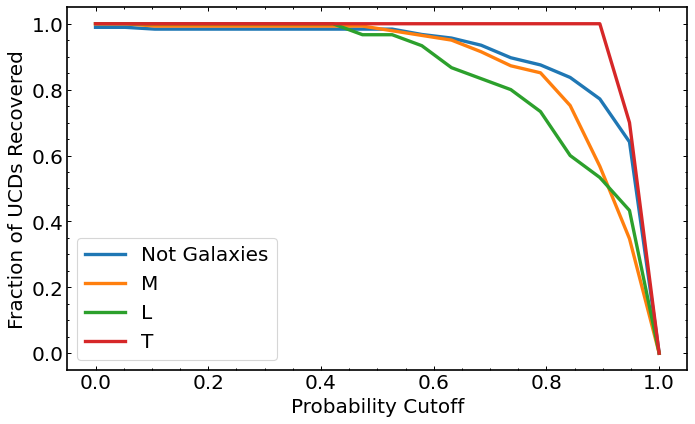

In [ ]:
fig, ax=plt.subplots(figsize=(10, 6))
plt.plot(np.linspace(0, 1, 20), recovs[:,0], label='Not Galaxies', linewidth=3)
plt.plot(np.linspace(0, 1, 20), recovs[:,1], label='M', linewidth=3)
plt.plot(np.linspace(0, 1, 20), recovs[:,2], label='L', linewidth=3)
plt.plot(np.linspace(0, 1, 20), recovs[:,3], label='T', linewidth=3)


plt.xlabel('Probability Cutoff', fontsize=18)
plt.ylabel('Fraction of UCDs Recovered', fontsize=18)
plt.minorticks_on()

plt.legend(fontsize=18)
plt.savefig('/content/gdrive/My Drive/codes/rf_cutoff.pdf')

In [ ]:
#threshold cuts for random forest
cut0=0.01
cut1=0.8
cut2=0.8
cut3=0.85

In [ ]:
ucdsl=pred_set[(rprobs[:,1] <cut0)  & (pred_set.grism_id.isin(list(truebds)))]
ms=pred_set[(rprobs[:,2] >cut1)  & (pred_set.grism_id.isin(list(truebds)))]
ls=pred_set[(rprobs[:,3] >cut2) & (pred_set.grism_id.isin(list(truebds)))]
ts=pred_set[(rprobs[:,4] >cut3)  & (pred_set.grism_id.isin(list(truebds)))]

In [ ]:
print ('RF results')
print ("-----------------------------------------------")
print (" recoverd {} UCDS out of {} total  with {} true ".format(len(ucdsl), len((rprobs[rprobs[:,1] <cut0])),  168 ))
print (" recoverd {} M7-L0 out of {} total  with {} true ".format(len(ms), len((rprobs[rprobs[:,2] >cut1])),  len(truems) ))
print (" recoverd {} Ls out of {} total  with {} true ".format(len(ls), len((rprobs[rprobs[:,3] >cut2])),  len(truels) ))
print (" recoverd {} Ts out of {} total  with {} true ".format(len(ts), len((rprobs[rprobs[:,4] >cut3])),  len(truets) ))

RF results
-----------------------------------------------
 recoverd 59 UCDS out of 75636 total  with 168 true 
 recoverd 117 M7-L0 out of 174 total  with 141 true 
 recoverd 21 Ls out of 40 total  with 30 true 
 recoverd 10 Ts out of 12 total  with 10 true 


In [ ]:
(pred_set.loc[rlabels>1]).grism_id.to_csv('/content/gdrive/My Drive/codes/selected_by_rf.csv')

In [ ]:
108+21+10, 174+40+12

(139, 226)

In [ ]:
cut1, cut2, cut3

(0.8, 0.8, 0.85)